<a href="https://colab.research.google.com/github/Osakhra/ITAI2373-NewsBot-Final/blob/main/notebooks/03_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03_Topic_Modeling.ipynb

In this notebook, we use topic modeling (LDA and NMF) to discover and visualize underlying themes in the news articles.


In [1]:
!pip install langdetect spacy nltk scikit-learn pyldavis textblob transformers torch sumy sentence-transformers numpy matplotlib seaborn googletrans==4.0.0-rc1
import nltk
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gensim to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!git clone https://github.com/Osakhra/ITAI2373-NewsBot-Final.git
import sys
sys.path.append('/content/ITAI2373-NewsBot-Final/src')


Cloning into 'ITAI2373-NewsBot-Final'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 202 (delta 15), reused 6 (delta 6), pack-reused 170 (from 1)
Receiving objects: 100% (202/202), 112.15 KiB | 2.95 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [3]:
from google.colab import files
uploaded = files.upload()  # Click to upload 'BBC News Train.csv' from your computer


Saving BBC News Train.csv to BBC News Train.csv


In [7]:
from data_processing.text_preprocessor import TextPreprocessor
pre = TextPreprocessor()
df['clean_content'] = df['content'].apply(pre.preprocess)


In [5]:
from analysis.topic_modeler import TopicModeler

tm = TopicModeler(n_topics=5, method='lda', max_features=1500)  # LDA with 5 topics, adjust as needed


In [8]:
doc_topic_matrix = tm.fit_transform(df['clean_content'])


In [9]:
topics = tm.get_all_topics(n_words=8)
for topic_id, words in topics.items():
    print(f"Topic {topic_id}: {', '.join(words)}")


Topic 0: say, use, people, mobile, phone, make, technology, service
Topic 1: say, mr, government, uk, law, people, plan, new
Topic 2: say, year, mr, company, market, firm, rise, sale
Topic 3: say, mr, game, labour, election, play, england, win
Topic 4: film, good, year, say, award, star, make, win


In [10]:
df['main_topic'] = [tm.assign_topic(text) for text in df['clean_content']]
df[['content', 'main_topic']].head()


,content,main_topic
0,worldcom ex-boss launches defence lawyers defe...,2
1,german business confidence slides german busin...,2
2,bbc poll indicates economic gloom citizens in ...,2
3,lifestyle governs mobile choice faster bett...,0
4,enron bosses in $168m payout eighteen former e...,2


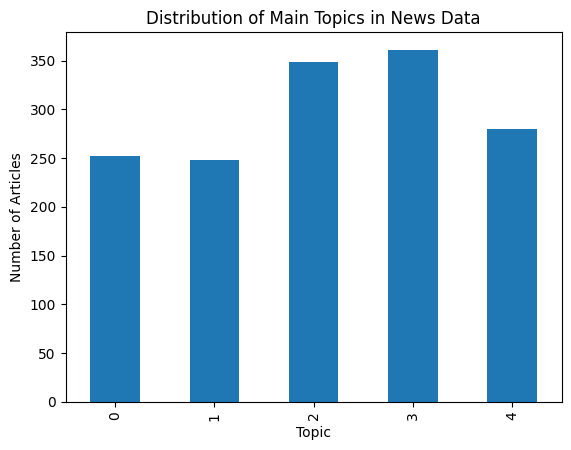

In [11]:
import matplotlib.pyplot as plt
df['main_topic'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Distribution of Main Topics in News Data')
plt.show()


Deciding to try and use pyLDAvis in Colab.
Update: Was unable at first, however with AI helper we learned that pyLDAvis.prepare function requires additional arguments, specifically the vocabulary and term frequencies.

I modified the code to provide these arguments, which can be extracted from the tm.vectorizer. pyLDAvis.prepare is expecting a different input format when using scikit-learn's LDA model.


After one more error I found that according to the pyLDAvis documentation, the correct way to use it with scikit-learn's LDA is to use pyLDAvis.sklearn.prepare and provide the fitted model and the document-term matrix. I updated the code to use this approach.

In [23]:
!pip install pyldavis

In [16]:
import pyLDAvis

# This enables inline visualization in Colab/Jupyter
pyLDAvis.enable_notebook()

In [21]:
# Transform your cleaned documents again (as CountVectorizer expects raw tokens, not TF-IDF)
X = tm.vectorizer.transform(df['clean_content'])

# Get necessary components for pyLDAvis.prepare
topic_term_dists = tm.model.components_
doc_topic_dists = tm.model.transform(X)
doc_lengths = X.sum(axis=1).A1
vocab = tm.vectorizer.get_feature_names_out()
term_freq = X.sum(axis=0).A1

# Prepare visualization data
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_freq
)

# Display the visualization inline
pyLDAvis.display(vis_data)